In [10]:
import xarray as xr, numpy as np, pandas as pd, glob, os
import regionmask, geopandas as gpd
import matplotlib, matplotlib.pyplot as plt, cartopy

mapproj = cartopy.crs.PlateCarree()

from xclim.core.units import convert_units_to

from geopy.geocoders import Nominatim
def get_latlon(city):
    
    # retrieve lat & lon for given location
    location = Nominatim(user_agent="GetLoc").geocode(city)
    if location is None:
        return {"lon" : None, "lat" : None}
    else:
        return {"lon" : location.longitude, "lat" : location.latitude}

xn,xx,yn,yx = [-120,-80,10,40]

In [7]:
! wget https://climexp.knmi.nl/data/era5_tp_daily_extended_-120--80E_10-40N_-999-lastyear_su.nc -O era5_tp.nc

--2025-10-15 13:47:48--  https://climexp.knmi.nl/data/era5_tp_daily_extended_-120--80E_10-40N_-999-lastyear_su.nc
Resolving climexp.knmi.nl (climexp.knmi.nl)... 2a0c:5bc0:4c:ff::9126:ce95, 145.38.206.149
Connecting to climexp.knmi.nl (climexp.knmi.nl)|2a0c:5bc0:4c:ff::9126:ce95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341110401 (325M) [application/x-netcdf]
Saving to: ‘era5_tp.nc’

era5_tp.nc          100%[===================>] 325.31M   258MB/s    in 1.3s    

2025-10-15 13:47:50 (258 MB/s) - ‘era5_tp.nc’ saved [341110401/341110401]



In [1]:
! wget https://climexp.knmi.nl/data/prcp_GLB_dailyNC_-120--80E_10-40N_firstyear-lastyear.nc -O cpc_precip.nc

--2025-10-15 10:02:45--  https://climexp.knmi.nl/data/prcp_GLB_dailyNC_-120--80E_10-40N_firstyear-lastyear.nc
Resolving climexp.knmi.nl (climexp.knmi.nl)... 2a0c:5bc0:4c:ff::9126:ce95, 145.38.206.149
Connecting to climexp.knmi.nl (climexp.knmi.nl)|2a0c:5bc0:4c:ff::9126:ce95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90054275 (86M) [application/x-netcdf]
Saving to: ‘cpc_precip.nc’

cpc_precip.nc       100%[===================>]  85.88M  69.0MB/s    in 1.2s    

2025-10-15 10:02:48 (69.0 MB/s) - ‘cpc_precip.nc’ saved [90054275/90054275]



# API request

In [ ]:
import cdsapi

dataset = "derived-era5-single-levels-daily-statistics"
request = {
    "product_type": "reanalysis",
    "variable": ["total_precipitation"],
    "year": "2025",
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "daily_statistic": "daily_sum",
    "time_zone": "utc+00:00",
    "frequency": "1_hourly",
    "area": [33, -118, 14, -86]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

# Spatial domain

In [2]:
elev = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/elev.0.25-deg.nc", decode_times = False).squeeze(drop = True).data

elev = elev.sel(lon = slice(360-120,360-90), lat = slice(35,13))

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/xarray/coding/times.py:213: SerializationWarning: Ambiguous reference date string: 1-1-1 0:0:0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 0:0:0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  ref_date = _ensure_padded_year(ref_date)


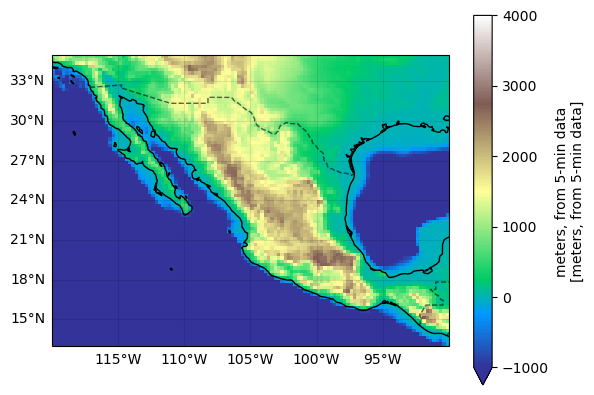

In [3]:
fig = elev.plot(cmap = "terrain", vmax = 4000, vmin = -1000, subplot_kws = {"projection" : mapproj})
ax = plt.gca()

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

## Admin regions

In [4]:
sf = gpd.read_file("sf_adm1")
sf2_idx = sf.clip((-100,10,-95,40)).index
sf2_idx = [i for i in sf2_idx if not i in [11, 6]]
sf2 = sf.loc[sf2_idx].dissolve().explode()
sf2 = sf2.loc[sf2.geometry.area == sf2.geometry.area.max()]

/var/tmp/pbs.1063496.pbs-7/ipykernel_3007789/3104470123.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sf2 = sf2.loc[sf2.geometry.area == sf2.geometry.area.max()]


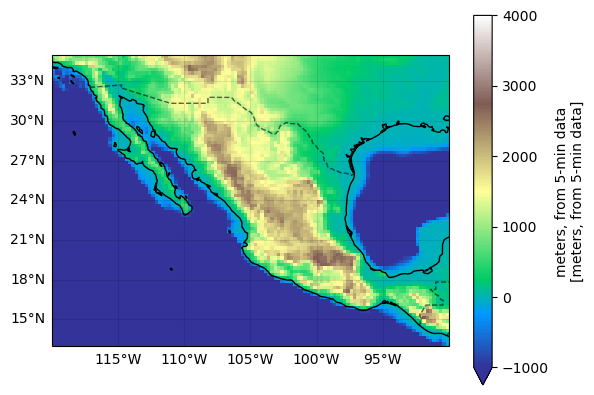

In [5]:
fig = elev.plot(cmap = "terrain", vmax = 4000, vmin = -1000, subplot_kws = {"projection" : mapproj})
ax = plt.gca()

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

# sf2.boundary.plot(ax = ax, color = "darkred", lw = 1)
# sf.clip(sf2).boundary.plot(ax = ax, color = "darkred", ls = "--", lw = 0.5)

## River basins

In [ ]:
hybas04 = gpd.read_file("sf_hybas04").clip(sf2)
hybas05 = gpd.read_file("sf_hybas05").clip(sf2)
hybas06 = gpd.read_file("sf_hybas06").clip(sf2)

In [ ]:
fig, axs = plt.subplots(ncols = 3, figsize = (12,4), subplot_kw = {"projection" : mapproj, "extent" : (-105,-90,15,30)})

for i in range(3):

    ax = axs[i]
    elev.plot(ax = ax, cmap = "terrain", vmax = 4000, vmin = -1000, add_colorbar = False)
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

    hybas = [hybas04, hybas05, hybas06][i]
    hybas.clip(sf2).boundary.plot(ax = ax, color = "darkred", ls = "--", lw = 0.5)

### Select basins east of mountains

In [ ]:
nc = 4; nr = 3

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*3, nr*4), dpi = 100)

for i in range(len(hybas04)):
    ax = axs.flatten()[i]
    
    hybas04.boundary.plot(ax = ax)
    hybas04.iloc[[i]].plot(ax = ax, color = "tab:orange")
    ax.set_title(str(hybas04.iloc[i].name))

In [ ]:
sf_hybas04 = hybas04.loc[[150,151,152,153]].dissolve().explode()
sf_hybas04 = sf_hybas04.loc[sf_hybas04.geometry.area == sf_hybas04.geometry.area.max()]

In [ ]:
sf_hybas04.to_file("sf_mx-gulfcoast")

In [ ]:
sf_hybas04.boundary.plot()

In [15]:
sf_hybas04.bounds

,minx,miny,maxx,maxy
0,-101.883333,16.9,-94.895266,26.04202


<GeoAxes: xlabel='lon [degrees_east]', ylabel='lat [degrees_north]'>

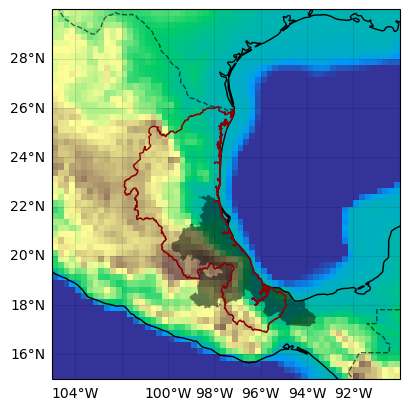

In [11]:
fig = elev.plot(cmap = "terrain", vmax = 4000, vmin = -1000, add_colorbar = False, subplot_kws = {"projection" : mapproj, "extent" : (-105,-90,15,30)})
ax = plt.gca()
    
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

sf_hybas04.boundary.plot(ax = ax, color = "darkred", lw = 1)

sf.iloc[[12, 20,29]].plot(ax = ax, alpha = 0.5, color = "k")

## Impacted regions

In [285]:
sites = ["Huauchinango, MX", "Cerro Azul, MX", "Cuetzalan del Progreso, MX", "Poza Rica, MX"]
states = ['Hidalgo', 'Puebla', 'Veracruz de Ignacio de la Llave', 'Querétaro de Arteaga']

In [290]:
sf_states = sf.loc[[s in states for s in sf.ADM1_ES]]
sf_states2 = sf.loc[[s in ['Hidalgo', 'Veracruz de Ignacio de la Llave'] for s in sf.ADM1_ES]]

In [ ]:
px = pd.DataFrame({s : get_latlon(s) for s in sites}).transpose()

In [ ]:
mc = get_latlon("Mexico City")

### Plot against event

In [311]:
era5 = xr.open_dataset("era5_tp.nc").tp.sel(time = slice("2025-10-08", "2025-10-10")).sum("time")
rm = regionmask.defined_regions.natural_earth_v5_1_2.land_50.mask(era5)
era5 = era5.where(rm == 0)

cpc = xr.open_dataset("cpc_precip.nc").precip.sel(time = slice("2025-10-08", "2025-10-10")).sum("time")
rm = regionmask.defined_regions.natural_earth_v5_1_2.land_50.mask(cpc)
cpc = cpc.where(rm == 0)

Text(0.5, 0.9, 'Total rainfall, October 8th-10th')

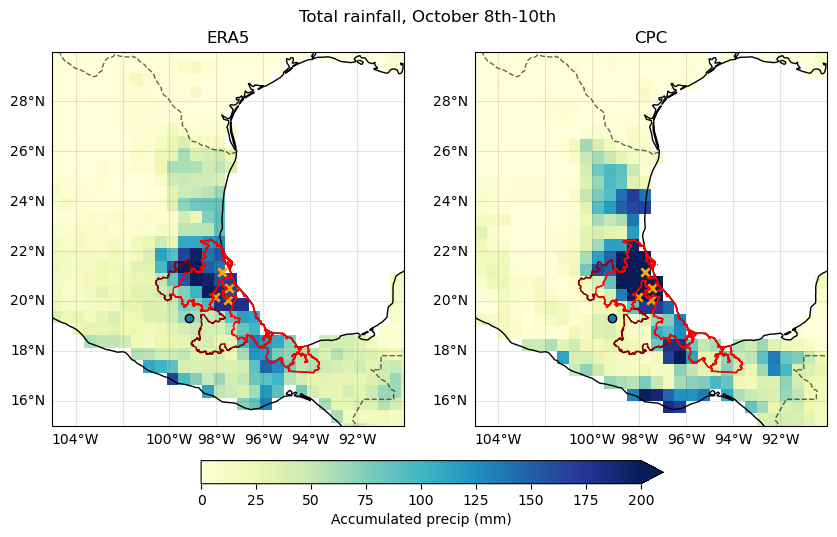

In [361]:
nc = 2
fig, axs = plt.subplots(ncols = nc, figsize = (nc*5, 6), dpi = 100, subplot_kw = {"projection" : mapproj, "extent" : (-105,-90,15,30)})

for i in range(nc):
    ax = axs[i]
    ds_nm = ["ERA5", "CPC"][i]
    da = eval(ds_nm.lower())

    cbar = da.plot(ax = ax, cmap = "YlGnBu", vmin = 0, vmax = 200, add_colorbar = False)

    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])
    ax.set_title(ds_nm)

    sf_states.dissolve().boundary.plot(ax = ax, color = "darkred", lw = 1)
    sf_states2.dissolve().boundary.plot(ax = ax, color = "red", lw = 1)

    ax.scatter(px.lon, px.lat, marker = "x", color = "orange", lw = 2)
    ax.scatter(*mc.values(), ec = "k")

plt.colorbar(cbar, ax = axs, label = "Accumulated precip (mm)", extend = "max", location = "bottom", fraction = 0.05, pad = 0.075)
plt.suptitle("Total rainfall, October 8th-10th", y = 0.9)

### Plot against elevation

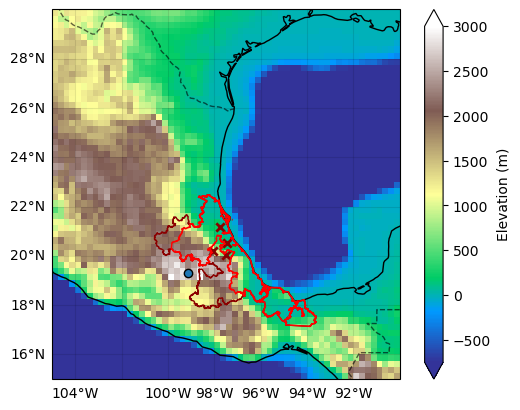

In [360]:
fig = elev.plot(cmap = "terrain", vmax = 3000, vmin = -750, subplot_kws = {"projection" : mapproj, "extent" : (-105,-90,15,30)},
               cbar_kwargs = {"label" : "Elevation (m)"})
ax = plt.gca()

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

sf_states.dissolve().boundary.plot(ax = ax, color = "darkred", lw = 1)
sf_states2.dissolve().boundary.plot(ax = ax, color = "red", lw = 1)

ax.scatter(px.lon, px.lat, marker = "x", color = "darkred", lw = 2)
ax.scatter(*mc.values(), ec = "k")

### Compare to river basins

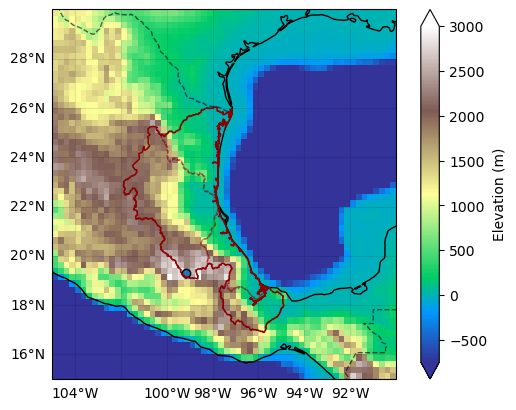

In [359]:
fig = elev.plot(cmap = "terrain", vmax = 3000, vmin = -750, subplot_kws = {"projection" : mapproj, "extent" : (-105,-90,15,30)},
               cbar_kwargs = {"label" : "Elevation (m)"})
ax = plt.gca()

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

hybas04.loc[[150,151,152,153]].dissolve().explode().boundary.plot(ax = ax, color = "darkred", lw = 1)
hybas04.loc[[150,151,152,153]].boundary.plot(ax = ax, color = "darkred", alpha = 0.4, ls = "--", lw = 1)

ax.scatter(*mc.values(), ec = "k")

Text(0.5, 0.9, 'Total rainfall, October 8th-10th')

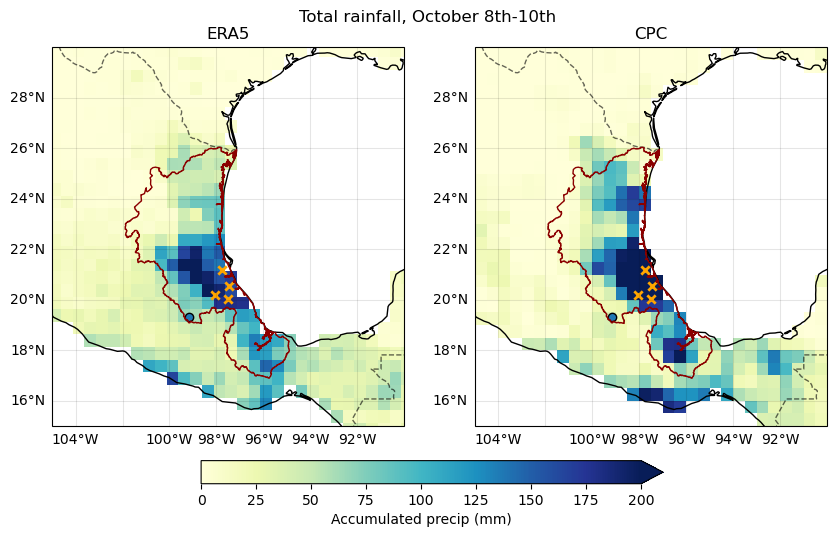

In [362]:
nc = 2
fig, axs = plt.subplots(ncols = nc, figsize = (nc*5, 6), dpi = 100, subplot_kw = {"projection" : mapproj, "extent" : (-105,-90,15,30)})

for i in range(nc):
    ax = axs[i]
    ds_nm = ["ERA5", "CPC"][i]
    da = eval(ds_nm.lower())

    cbar = da.plot(ax = ax, cmap = "YlGnBu", vmin = 0, vmax = 200, add_colorbar = False)

    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])
    ax.set_title(ds_nm)
    ax.scatter(*mc.values(), ec = "k")

    hybas04.loc[[150,151,152,153]].dissolve().explode().boundary.plot(ax = ax, color = "darkred", lw = 1)

    ax.scatter(px.lon, px.lat, marker = "x", color = "orange", lw = 2)

plt.colorbar(cbar, ax = axs, label = "Accumulated precip (mm)", extend = "max", location = "bottom", fraction = 0.05, pad = 0.075)
plt.suptitle("Total rainfall, October 8th-10th", y = 0.9)

## Koppen-Geiger

In [ ]:
kg = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/koppen-geiger/kg_classifications.nc").kg_cat.sel(lon = slice(-105,-90), lat = slice(15,30))

# group individual classes into broader categories
kg_grouped = xr.apply_ufunc(np.digitize, kg, kwargs={'bins': [0.5,3.5,7.5,16.5,28.5,30]})

Text(0.5, 1.0, 'Koppen-Geiger climatology')

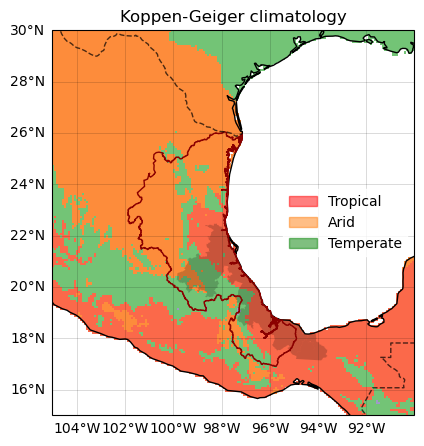

In [403]:
fig, ax = plt.subplots(ncols = 1, figsize = (7,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
kg_grouped.where(kg_grouped == 1).plot(ax = ax, cmap = "Reds", add_colorbar = False)      # tropical
kg_grouped.where(kg_grouped == 2).plot(ax = ax, cmap = "Oranges", add_colorbar = False)   # arid
kg_grouped.where(kg_grouped == 3).plot(ax = ax, cmap = "Greens", add_colorbar = False)    # temperate
kg_grouped.where(kg_grouped == 4).plot(ax = ax, cmap = "Blues", add_colorbar = False)     # cold
kg_grouped.where(kg_grouped == 5).plot(ax = ax, cmap = "Purples", add_colorbar = False)   # polar

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)

plt.legend(handles = [matplotlib.patches.Patch(color = "red", label = "Tropical", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "tab:orange", label = "Arid", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "green", label = "Temperate", alpha = 0.5), 
                      # matplotlib.patches.Patch(color = "tab:blue", label = "Cold", alpha = 0.5),
                      # matplotlib.patches.Patch(color = "purple", label = "Polar", alpha = 0.3)
                     ], 
           edgecolor = "w", loc = "right")

hybas04.loc[[150,151,152,153]].dissolve().explode().boundary.plot(ax = ax, color = "darkred", lw = 1)

sf_states2.dissolve().plot(ax = ax, color = "k", alpha = 0.2)

plt.title("Koppen-Geiger climatology")

## Ecoregions

In [409]:
sf_eco = gpd.read_file("sf_ecoregions").clip((-105,15,-90,30))

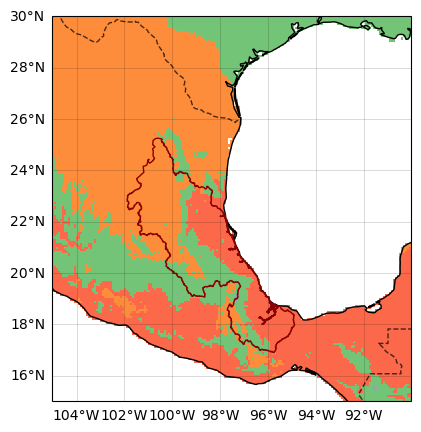

In [431]:
fig, ax = plt.subplots(ncols = 1, figsize = (7,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
kg_grouped.where(kg_grouped == 1).plot(ax = ax, cmap = "Reds", add_colorbar = False)      # tropical
kg_grouped.where(kg_grouped == 2).plot(ax = ax, cmap = "Oranges", add_colorbar = False)   # arid
kg_grouped.where(kg_grouped == 3).plot(ax = ax, cmap = "Greens", add_colorbar = False)    # temperate
kg_grouped.where(kg_grouped == 4).plot(ax = ax, cmap = "Blues", add_colorbar = False)     # cold
kg_grouped.where(kg_grouped == 5).plot(ax = ax, cmap = "Purples", add_colorbar = False)   # polar

hybas04.loc[[151,152,153]].dissolve().explode().boundary.plot(ax = ax, color = "darkred", lw = 1)

# sf_eco.boundary.plot(ax = ax, color = "k", lw = 1)

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)

In [ ]:
sf_eco.clip((-100,24,-98,28)).plot()

In [424]:
sf_eco2 = pd.concat([sf_eco.loc[sf_eco.CVEECON1 == v].dissolve() for v in list(set(sf_eco.CVEECON1))])

<Axes: >

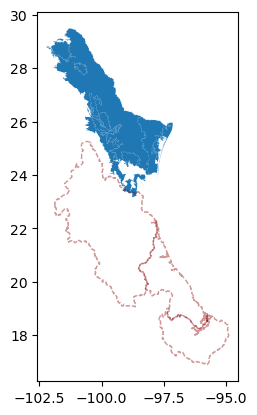

In [429]:
sf_eco.loc[sf_eco.CVEECON1 == 9.0].plot()
hybas04.loc[[151,152,153]].boundary.plot(ax = plt.gca(), color = "darkred", alpha = 0.4, ls = "--", lw = 1)


# Quick event maps

In [ ]:
mx = regionmask.defined_regions.natural_earth_v5_1_2.countries_50.to_geodataframe().set_index("abbrevs").loc[["MX"]]
mx = mx.dissolve().explode()
mx = mx.loc[mx.geometry.area == mx.geometry.area.max()]

In [ ]:
mx.boundary.plot()

ax = plt.gca()
[ax.axvline(x, color = "k", ls = "--", lw = 1) for x in [-95,-105]]
[ax.axhline(y, color = "k", ls = "--", lw = 1) for y in [15,30]]

## ERA5

In [136]:
da = xr.open_dataset("era5_tp.nc").tp

rm = regionmask.defined_regions.natural_earth_v5_1_2.land_50.mask(da)
da = da.where(rm == 0)

In [15]:
sf = gpd.read_file("sf_adm1")

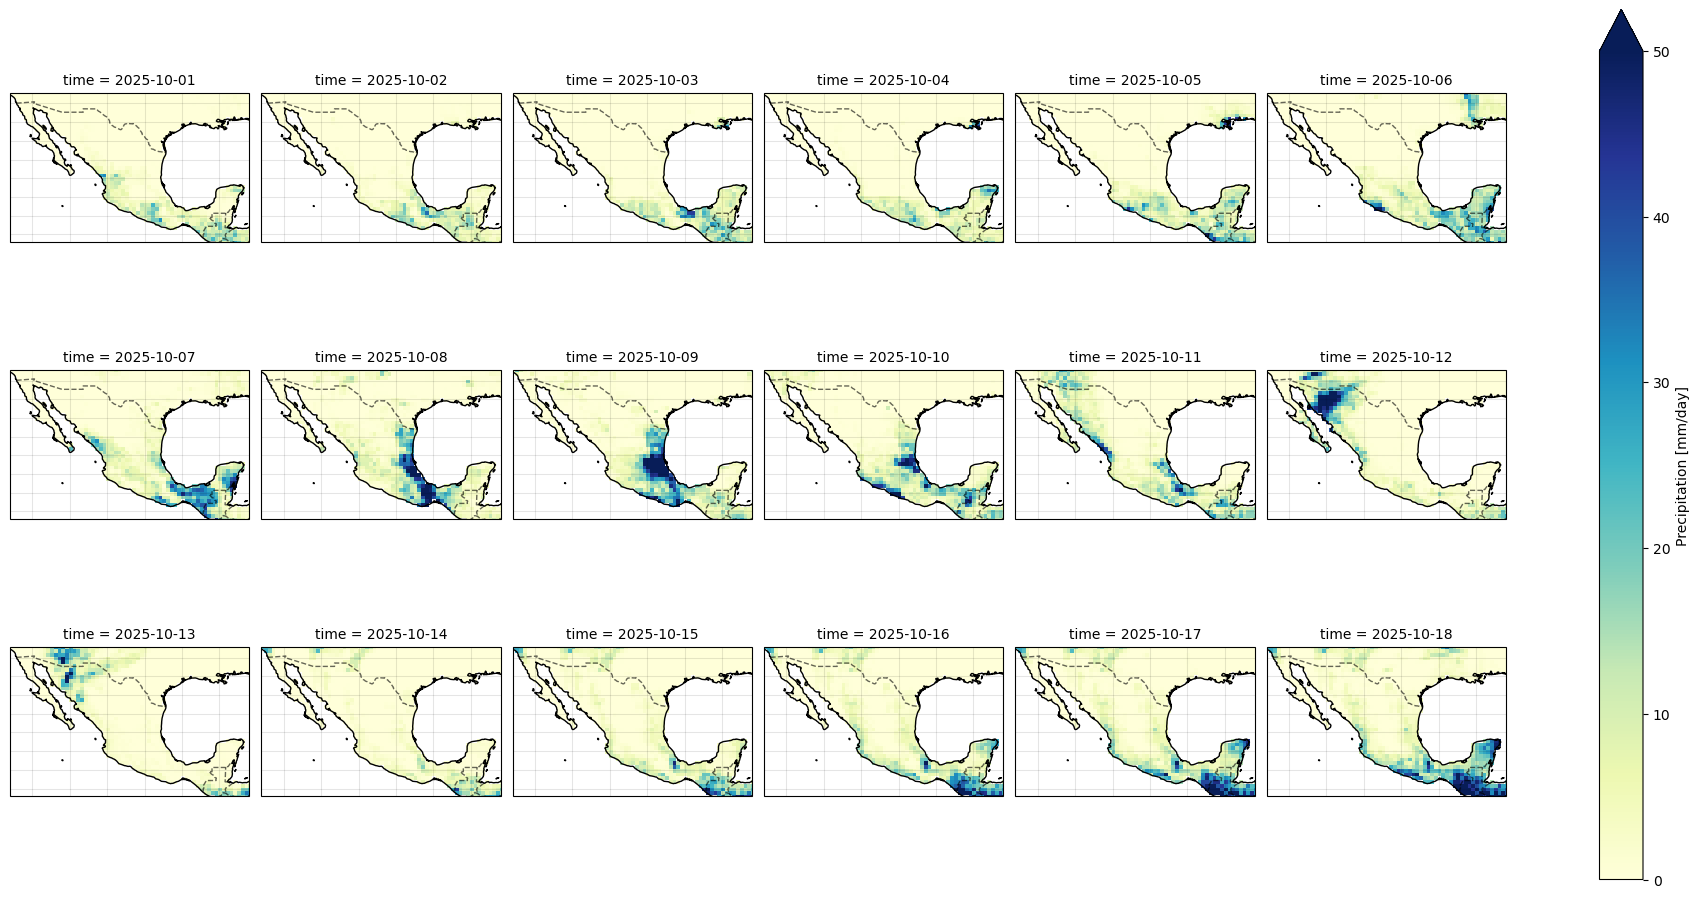

In [21]:
fig = da.sel(time = "2025-10").plot(col = "time", col_wrap = 6, cmap = "YlGnBu", vmin = 0, vmax = 50,
                                                 subplot_kws = {"projection" : mapproj, "extent" : (-118,-86,14,33)})
for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)                # add national borders
    ax.gridlines(color = "k", alpha = 0.1)                                         # add gridlines but don't draw the labels
    ax.coastlines(color = "k")                                                     # add coastlines

## CPC

In [5]:
da = xr.open_dataset("cpc_precip.nc").precip

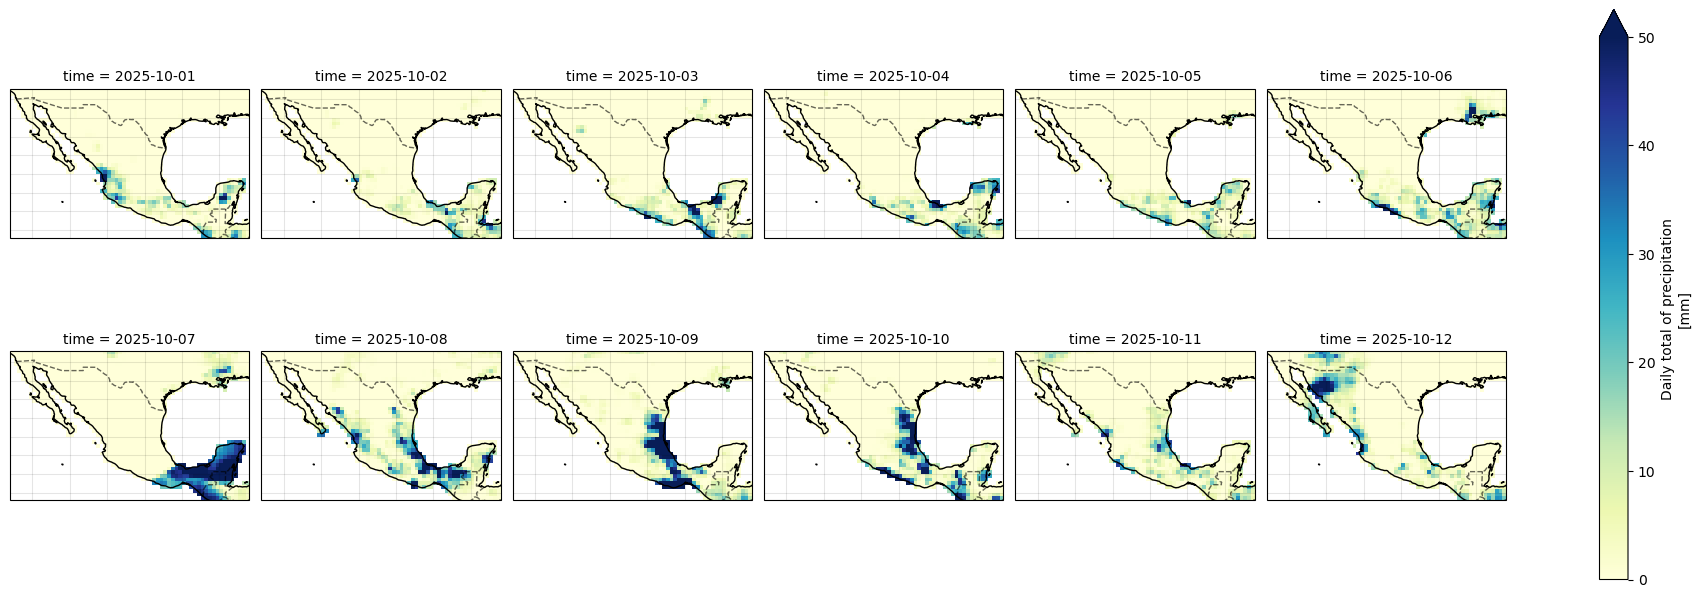

In [6]:
fig = da.sel(time = "2025-10").plot(col = "time", col_wrap = 6, cmap = "YlGnBu", vmin = 0, vmax = 50,
                                                 subplot_kws = {"projection" : mapproj, "extent" : (-118,-86,14,33)})
for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)                # add national borders
    ax.gridlines(color = "k", alpha = 0.1)                                         # add gridlines but don't draw the labels
    ax.coastlines(color = "k")                                                     # add coastlines

# Quick time series

In [ ]:
da = xr.open_dataset("era5_tp.nc").tp
ts = da.where(regionmask.mask_geopandas(sf_hybas04, da) == 0, drop = True).mean(["lat", "lon"])
ts.rename("pr").to_netcdf("ts-daily_era5.nc")

In [220]:
da = xr.open_dataset("cpc_precip.nc").precip
ts = da.where(regionmask.mask_geopandas(sf_hybas04, da) == 0, drop = True).mean(["lat", "lon"])
ts.rename("pr").to_netcdf("ts-daily_cpc.nc")

## Duration & season

In [364]:
era5 = xr.open_dataset("ts-daily_era5.nc").pr
cpc = xr.open_dataset("ts-daily_cpc.nc").pr

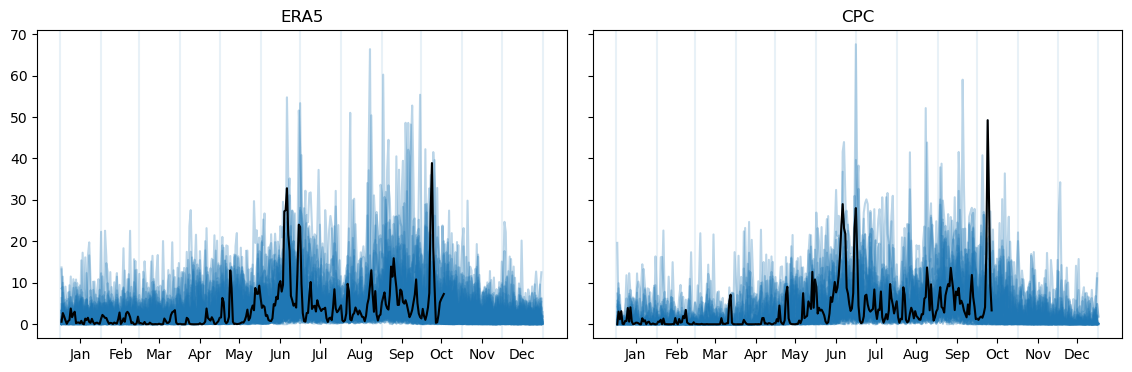

In [370]:
# How unusual was this year?
fig, axs = plt.subplots(ncols = 2, figsize = (14,4), dpi = 100, sharey = True)
plt.subplots_adjust(wspace = 0.05)

for i in range(2):
    ax = axs[i]
    ts = [era5, cpc][i]
    ts_nm = ["ERA5", "CPC"][i]

    # loop over each year & plot the annual time series
    for y in np.unique(ts.time.dt.year):
        ts_y = ts.sel(time = str(y))
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.3)
    
    # add the event year in a different colour
    ts_y = ts.sel(time = "2025")
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k")
    
    # make nicer x-axis labels (don't change this part)
    days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
    labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
    labels = [days[i].strftime("%b") for i in range(len(days)) if (days[i].day) == 15]
    
    [ax.axvline(i, alpha = 0.1) for i in range(len(days)) if (days[i].day) == 1]
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    
    ax.set_title(ts_nm)

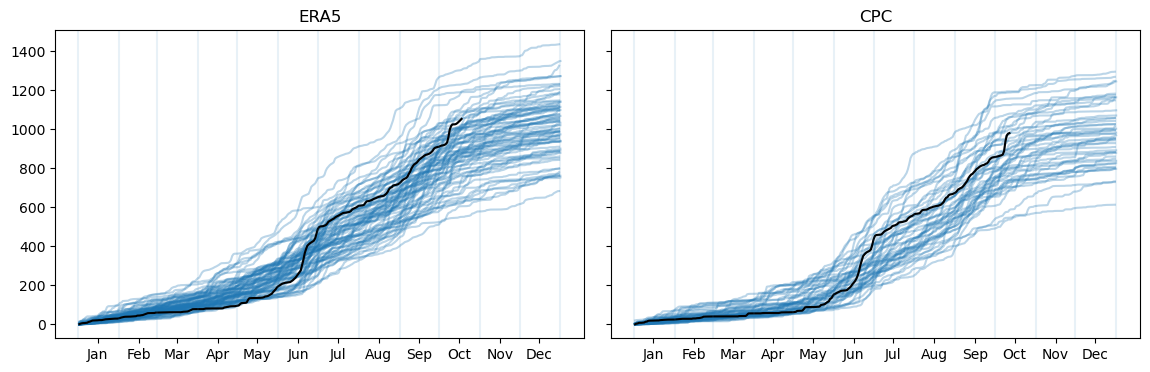

In [371]:
# How unusual was this year?
fig, axs = plt.subplots(ncols = 2, figsize = (14,4), dpi = 100, sharey = True)
plt.subplots_adjust(wspace = 0.05)

for i in range(2):
    ax = axs[i]
    ts = [era5, cpc][i]
    ts_nm = ["ERA5", "CPC"][i]

    # loop over each year & plot the annual time series
    for y in np.unique(ts.time.dt.year):
        ts_y = ts.sel(time = str(y))
        ax.plot(ts_y.time.dt.dayofyear, ts_y.cumsum(), color = "tab:blue", alpha = 0.3)
    
    # add the event year in a different colour
    ts_y = ts.sel(time = "2025")
    ax.plot(ts_y.time.dt.dayofyear, ts_y.cumsum(), color = "k")
    
    # make nicer x-axis labels (don't change this part)
    days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
    labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
    labels = [days[i].strftime("%b") for i in range(len(days)) if (days[i].day) == 15]
    
    [ax.axvline(i, alpha = 0.1) for i in range(len(days)) if (days[i].day) == 1]
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    
    ax.set_title(ts_nm)

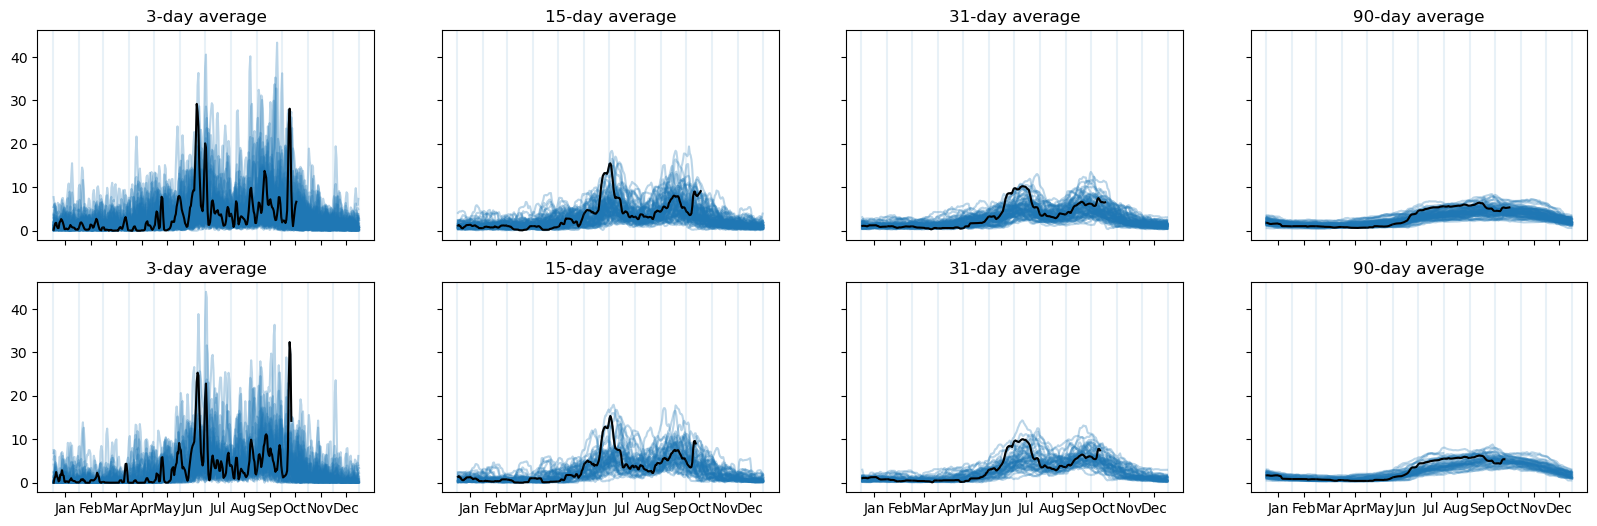

In [244]:
# Compare a few accumulations
nc = 4; nr = 2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5,nr * 3), dpi = 100, sharey = True, sharex = True)

# loop over each year & plot the annual time series
for j in range(2):
    ts = [era5, cpc][j]
    ts_nm = ["ERA5", "CPC"][j]
    
    for i in range(4):
        ax = axs[j,i]
        ndays = [3,15,31,90][i]     # change the numbers of days to compare different accumulations
        
        ts_nday = ts.rolling(time = ndays, center = False).mean()
        
        for y in np.unique(ts.time.dt.year):
            ts_y = ts_nday.sel(time = str(y))
            ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.3)
    
        # add this year in a different colour
        ts_y = ts_nday.sel(time = "2025")
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k") 
            
        ax.set_xticks(labelticks)
        ax.set_xticklabels(labels)
        [ax.axvline(i, alpha = 0.1) for i in range(367) if (days[i].day) == 1]
        
        ax.set_title(str(ndays)+"-day average")
        
        # # add a rectangle shading the time period of interest (get & set ylims to avoid resizing the plot)
        # ylim = ax.get_ylim()
        # ax.add_patch(Rectangle((pr_ts.sel(time = "2023-07-01").time.dt.dayofyear.values,-5), 20, 300, color = "gold", alpha = 0.3)) # 20-day period starting from July 1st
        # ax.set_ylim(ylim)
    
    

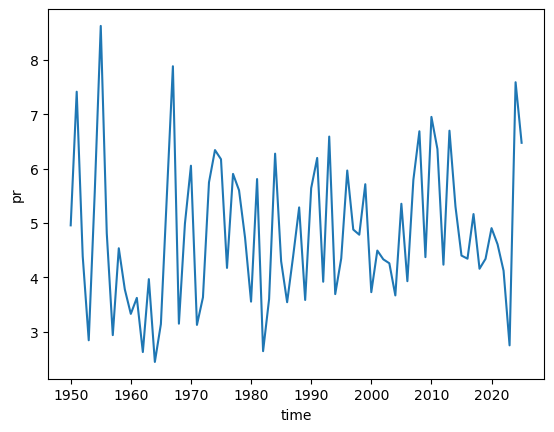

In [376]:
era5.sel(time = era5.time.dt.month.isin([6,7,8,9,10])).resample(time = "YS").std().plot()

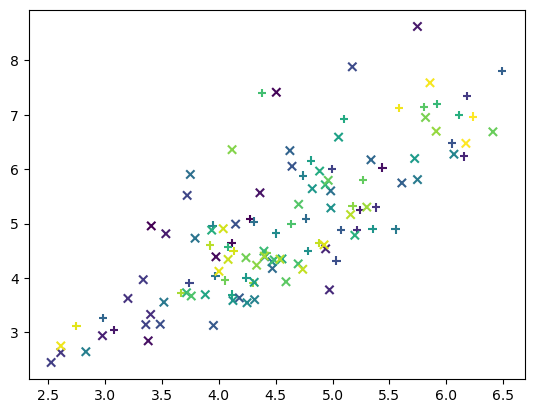

In [386]:
plt.scatter(cpc.sel(time = cpc.time.dt.month.isin([6,7,8,9,10])).resample(time = "YS").mean(),
            cpc.sel(time = cpc.time.dt.month.isin([6,7,8,9,10])).resample(time = "YS").std(),
            c = cpc.sel(time = cpc.time.dt.month.isin([6,7,8,9,10])).resample(time = "YS").mean().time.dt.year, 
            marker = "+")

plt.scatter(era5.sel(time = era5.time.dt.month.isin([6,7,8,9,10])).resample(time = "YS").mean(),
            era5.sel(time = era5.time.dt.month.isin([6,7,8,9,10])).resample(time = "YS").std(),
            c = era5.sel(time = era5.time.dt.month.isin([6,7,8,9,10])).resample(time = "YS").mean().time.dt.year,
            marker = "x")

# Look for stations with long time series


## GHCN-D

### Identify stations

In [ ]:
# choose stations

sf = gpd.read_file("sf_mx-gulfcoast/")

px_ghcnd = pd.read_csv("stations/ghcnd-stations_mx.csv", index_col = ["STATION"])[['NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']].drop_duplicates()
px_ghcnd = gpd.GeoDataFrame(px_ghcnd, geometry=gpd.points_from_xy(px_ghcnd.LONGITUDE, px_ghcnd.LATITUDE), crs="EPSG:4326")
px_ghcnd = px_ghcnd.clip(sf)

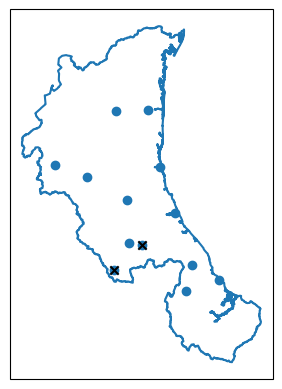

In [71]:
fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj})
sf.boundary.plot(ax = ax)
ax.scatter(px_ghcnd.LONGITUDE, px_ghcnd.LATITUDE)
ax.scatter(px_ghcnd.loc[["MXM00076680", "MXM00076634"]].LONGITUDE, px_ghcnd.loc[["MXM00076680", "MXM00076634"]].LATITUDE, marker = "x", color = "k")

In [ ]:
# ! wget https://www.ncei.noaa.gov/orders/cdo/4148063.csv -O stations/ghcnd-pr_4148063.csv
# ! wget https://www.ncei.noaa.gov/orders/cdo/4148064.csv -O stations/ghcnd-pr_4148064.csv

### Clean up station data

In [89]:
df = df = pd.concat([pd.read_csv(fnm, index_col = "DATE", parse_dates = ["DATE"]) for fnm in glob.glob("stations/ghcnd-pr_*.csv")])
df = pd.pivot(df, columns='STATION', values='PRCP')


In [ ]:
df.to_csv("stations/ghcnd-precip.csv")

In [ ]:
df.to_csv("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/obs/station-precip_ghcn-d.csv")

In [130]:
px_ghcnd.to_csv("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/obs/station-metadata_ghcn-d.csv")

## Climate explorer

### Identify stations

In [ ]:
px_cx = pd.read_csv("stations/cx-stations.csv", index_col = "id")[["station", "country", "lon", "lat"]]
px_cx = gpd.GeoDataFrame(px_cx, geometry=gpd.points_from_xy(px_cx.lon, px_cx.lat), crs="EPSG:4326")
px_cx = px_cx.clip(sf)
# SMN = military & government?

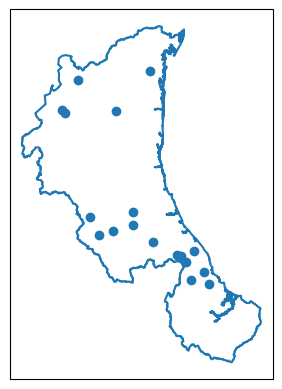

In [136]:
fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj})
sf.boundary.plot(ax = ax)
ax.scatter(px_cx.lon, px_cx.lat)

In [137]:
px_cx.sort_index()

,station,country,lon,lat,geometry
id,,,,,
MXM00076491,CIUDAD_VICTORIA,(Mexico),-99.13,23.73,POINT (-99.13 23.73)
MXN00013012,HUICHAPAN,(Mexico),-99.63,20.37,POINT (-99.63 20.37)
MXN00013013,IXMIQUILPAN_/SMN/,(SMN),-99.22,20.47,POINT (-99.22 20.47)
MXN00013042,ZACUALTIPAN_/SMN/,(SMN),-98.65,20.63,POINT (-98.65 20.63)
MXN00013048,TLANCHINOL_/SMN/,(SMN),-98.65,20.98,POINT (-98.65 20.98)
MXN00019050,SAN_JOSE_DE_RAICES,(Mexico),-100.23,24.57,POINT (-100.23 24.57)
MXN00021091,TEZIUTLAN,(Mexico),-97.35,19.82,POINT (-97.35 19.82)
MXN00021118,HUAUCHINANGO,(Mexico),-98.05,20.18,POINT (-98.05 20.18)
MXN00022017,TOLIMAN,(Mexico),-99.88,20.85,POINT (-99.88 20.85)


### Clean up station data


In [139]:
df = pd.read_table("stations/cx-station-precip.txt", skiprows = 2, sep = " +", engine = "python", 
              na_values = 0.3000000E+34, index_col = "date", parse_dates = ["date"])

df = df[px_cx.index].dropna(axis = 0, how = "all").dropna(axis = 1, how = "all")

In [138]:
# filter to only those points within the study region
df.to_csv("stations/station-precip_climexp.csv")

In [141]:
df.to_csv("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/obs/station-precip_climexp-ghcnd+gts.csv")

In [142]:
px_cx.to_csv("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/obs/station-metadata_climexp-ghcnd+gts.csv")

# MSWEP

In [3]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswep/"

In [4]:
outpath = "/rds/general/user/cb2714/home/99_ephemera/mx-floods/mswep/"

In [ ]:
for y in range(2025,1978,-1):
    fl = sorted(glob.glob(fpath+str(y)+"/*"))

    new_fnm = outpath+"mswep_"+str(y)+".nc"

    if os.path.exists(new_fnm): continue

    ds = xr.open_mfdataset(fl).sel(lon = slice(xn,xx), lat = slice(yx,yn))
    ds.to_netcdf(new_fnm)

# Sub-daily time series

In [ ]:
glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ep")

In [29]:
! module avail



----------------------------- /sw-eb/modules/all ------------------------------
   ABINIT/9.6.2-foss-2022a
   ABINIT/10.2.5-intel-2023a                                 (D)
   AFNI/24.0.02-foss-2023a
   ANTLR/2.7.7-GCCcore-12.3.0-Java-11
   ANTLR/2.7.7-GCCcore-13.3.0                                (D)
   ANTs/2.3.5-foss-2021a
   AOCL-BLAS/5.0-GCC-14.2.0
   AOCL-BLAS/5.1-GCC-14.3.0                                  (D)
   ASE/3.23.0-gfbf-2024a
   ASE/3.24.0-gfbf-2024a
   ASE/3.25.0-gfbf-2025.07                                   (D)
   ATK/2.36.0-GCCcore-10.3.0
   ATK/2.38.0-GCCcore-11.3.0
   ATK/2.38.0-GCCcore-12.2.0
   ATK/2.38.0-GCCcore-12.3.0
   ATK/2.38.0-GCCcore-13.2.0
   ATK/2.38.0-GCCcore-13.3.0                                 (D)
   AUGUSTUS/3.5.0-foss-2023a
   Abseil/20230125.2-GCCcore-12.2.0
   Abseil/20230125.3-GCCcore-12.3.0
   Abseil/20240116.1-GCCcore-13.2.0
m--More--